### Creating a Query and Loading a Dataset

In [1]:
from rdkit import Chem
from rdkit.Chem import rdDistGeom, rdForceFieldHelpers
from rdkit.Chem.Draw import IPythonConsole

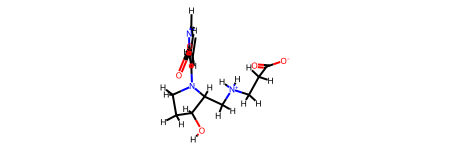

In [2]:
# query = Chem.MolFromSmiles("c1ccnc(C(=O)O)c1N2CCC(O)C2")
query = Chem.MolFromSmiles("c1ccnc(C(=O)O)c1N2CCC(O)C2C[NH2+]CCC(=O)[O-]")
query = Chem.AddHs(query)

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xd06f00d
ps.numThreads = 16

rdDistGeom.EmbedMultipleConfs(query, 10, ps)
rdForceFieldHelpers.MMFFOptimizeMolecule(query)

query

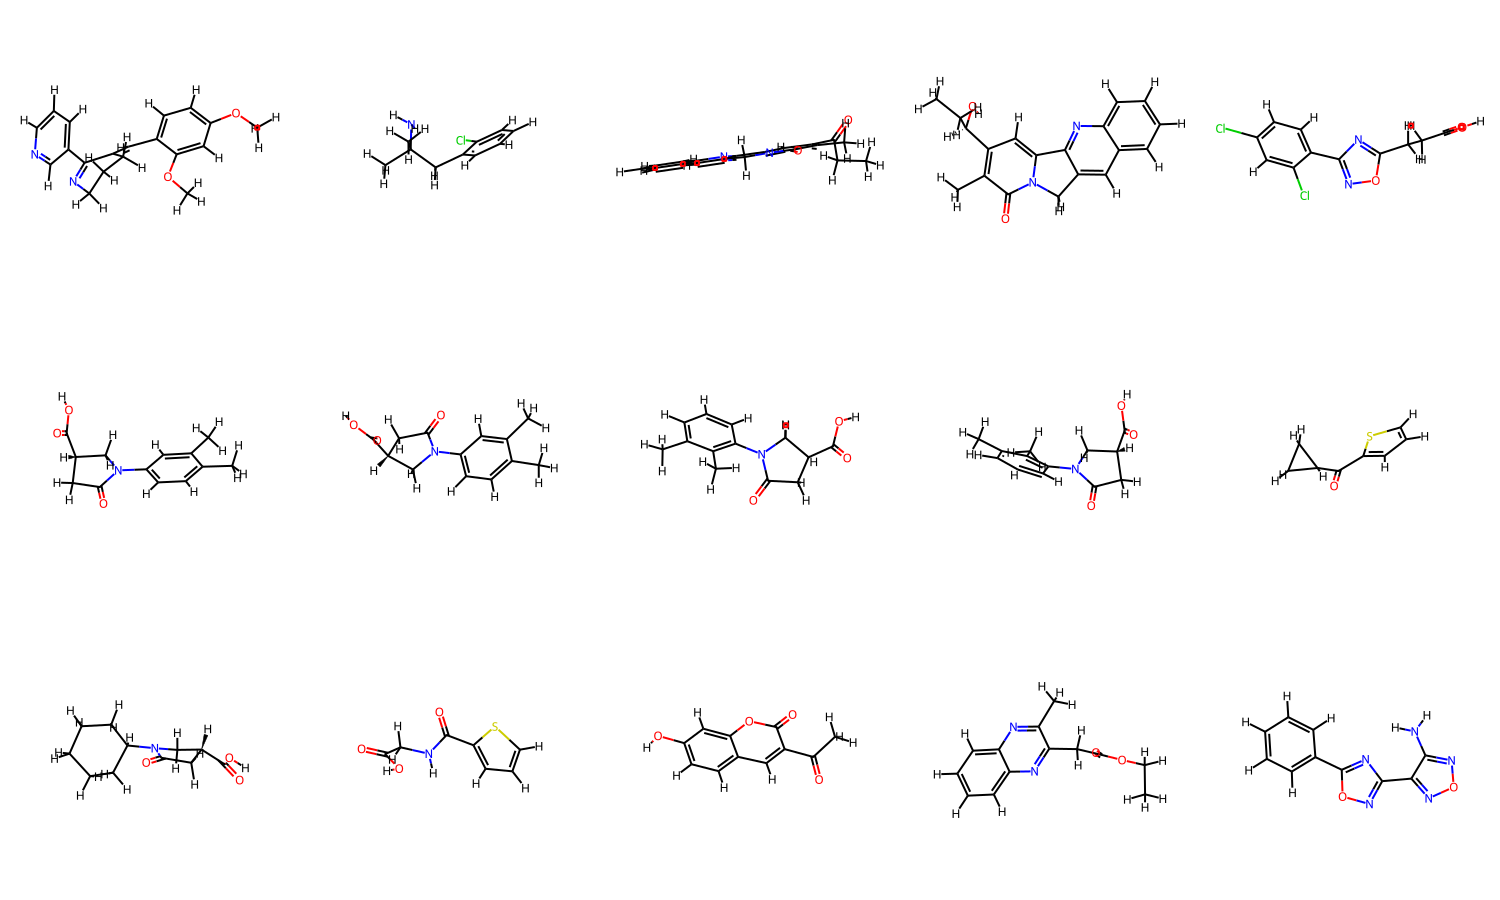

In [3]:
from druglab.storage import MolStorage

mols = [mol for mol in Chem.SmilesMolSupplier("examples.smi", titleLine=False)]
mols = [Chem.AddHs(mol) for mol in mols[:100]]
[rdDistGeom.EmbedMolecule(mol, ps) for mol in mols]
[rdForceFieldHelpers.MMFFOptimizeMolecule(mol) for mol in mols]

mols = MolStorage(mols)

IPythonConsole.ShowMols(mols[:15], molsPerRow=5, subImgSize=(300, 300))

### Creating a Pharmacophore Generator, Profiler, and Fingerprinter

In [4]:
from druglab.pharm import (
    PharmGenerator, BASE_DEFINITIONS_PATH,
    PharmProfiler, PharmDefaultProfiler,
    PharmFingerprinter, PharmCompositeFingerprinter, 
    PharmDistFingerprinter, PharmCosineFingerprinter
)

In [5]:
pgen = PharmGenerator()
pgen.load_file(BASE_DEFINITIONS_PATH)

profiler = PharmDefaultProfiler(pgen.ftypes, ngroup=3)
distfper = PharmCompositeFingerprinter(
    fpers=[
        PharmDistFingerprinter(bins=(1, 2, 3, 4, 5, 6, 7, 8)),
        PharmDistFingerprinter(bins=(0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5))
    ],
    mode="sum"
)
fper = PharmCompositeFingerprinter(
    fpers=[
        distfper,
        PharmCosineFingerprinter(bins=(-0.8, -0.6, -0.4, -0.2, 
                                       0, 0.2, 0.4, 0.6, 0.8))
    ],
    mode="prod",
    fpsize=8192
)

### Manual Generation of Pharmacophore FPs

In [6]:
import numpy as np

# 1) For a single conformer:
pharm = pgen.generate(query)
profile = profiler.profile(pharm)
fp = fper.fingerprint(profile)
print(fp.sum(), fp.shape)

# 2) For all the conformers:
pharm = pgen.generate(query, confid="all")
profile = profiler.profile(pharm)
fps = fper.fingerprint(profile)
print(fps.shape)
print("commonest ids:", np.flip(fps.mean(axis=0).argsort()))

# 3) Or merge all conformers:
fp = fper.fingerprint(profile, merge_confs=True)
print(fp.sum(), fp.shape)

927 (1, 8192)
(10, 8192)
commonest ids: [7865 8001 7753 ... 2022 7270 1543]
5295 (1, 8192)


### Automatically featurizing molecules in a MolStorage or ConformerStorage

In [7]:
from druglab.pharm import PharmFeaturizer

fer = PharmFeaturizer(pgen, profiler, fper)

In [11]:
fer.featurize(query).sum()

5295

In [12]:
mols.featurize(fer)

In [14]:
mols.feats.shape

(100, 8192)

[ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objects, 0 feats),
 ConformerStorage(0 objec